# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [2]:
RANDOM_STATE = 33

# Apartado 2: Recuperación de información

__Número de grupo: 14__

__Nombres de los estudiantes: Javier Fernández Parrondo y Carlos Murcia Morilla__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no lo vamos a usar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías.

Crea una partición estratificada de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("BBC_News.csv")

df["ArticleId"] = df["ArticleId"].astype("category")

df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
print("Training text: ", len(df))

Training text:  1490


In [5]:
frec = df.groupby(['Category']).count()
frec

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


In [6]:
x_train, x_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_STATE)
x_train

,ArticleId,Text,Category
1305,1004,microsoft releases bumper patches microsoft ha...,tech
600,530,newcastle line up babayaro newcastle manager g...,sport
237,495,arnesen denies rift with santini tottenham spo...,sport
1352,2148,charity single for quake relief singers includ...,entertainment
661,130,williams battles to aussie title serena willia...,sport
...,...,...,...
1225,1650,us trade gap ballooned in october the us trade...,business
658,1589,pre-poll clash on tax and spend labour and the...,politics
578,773,redford s vision of sundance despite sporting ...,entertainment
391,339,aids and climate top davos agenda climate chan...,business


In [7]:
x_test

,ArticleId,Text,Category
46,593,china ripe for media explosion asia is set t...,tech
462,2118,wales stars need a rest - ruddock wales coach ...,sport
729,245,swiss cement firm in buying spree swiss cement...,business
393,123,safety alert as gm recalls cars the world s bi...,business
899,2088,cyber criminals step up the pace so-called phi...,tech
...,...,...,...
231,140,rich grab half colombia poor fund half of the ...,business
854,1179,bbc web search aids odd queries the bbc s onli...,tech
368,295,china net cafe culture crackdown chinese autho...,tech
361,949,saudi ncci s shares soar shares in saudi arabi...,business


## 2) Representación basada en bolsa de palabras y tf-idf

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y el valor tf-idf de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y comenta las clases en las que se comporta mejor y peor. ¿Crees que los resultados son buenos?

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
vectorizer = CountVectorizer(stop_words='english', binary = False, ngram_range = (1,1)) 
train_vector_data=vectorizer.fit_transform(x_train.Text)

In [10]:
feature_names = vectorizer.get_feature_names()

print(len(feature_names))
print(feature_names[:3000])

22064
['00', '000', '0001', '000bn', '000m', '000th', '001', '001and', '001st', '0051', '007', '01', '0100', '028', '03', '033', '04', '041', '04bn', '04secs', '05', '050', '050505', '0530', '0530gmt', '056', '05bn', '05m', '06', '060', '0630', '069', '07', '070', '0710', '072', '08', '0800', '0870', '088', '09', '0900', '0950', '09bn', '09secs', '10', '100', '1000th', '100bn', '100m', '100ml', '101', '102', '103', '104', '105', '105m', '106', '106m', '108', '1080', '109', '10bn', '10ft', '10m', '10secs', '10th', '11', '110', '1100', '110m', '111', '1115', '112', '113', '1130', '113bn', '115', '116', '116i', '117', '117m', '118', '119', '119bn', '119m', '11bn', '11m', '11pm', '11th', '12', '120', '1200', '1200m', '120bn', '120gb', '120m', '121', '1215', '1230', '124bn', '125', '125m', '127th', '128', '129', '12bn', '12cm', '12m', '12th', '13', '130', '1300', '130m', '132', '133', '1330', '1337', '133m', '134', '135', '136', '137', '138m', '139', '13bn', '13m', '13secs', '13th', '14', '

In [11]:
print(train_vector_data[10])

  (0, 12929)	8
  (0, 14634)	1
  (0, 20968)	1
  (0, 20894)	1
  (0, 11622)	1
  (0, 17692)	4
  (0, 21675)	5
  (0, 15574)	1
  (0, 14635)	1
  (0, 11738)	1
  (0, 13866)	1
  (0, 10352)	1
  (0, 10701)	4
  (0, 7671)	4
  (0, 16475)	2
  (0, 20895)	1
  (0, 21293)	1
  (0, 12374)	1
  (0, 5666)	1
  (0, 17307)	4
  (0, 8215)	2
  (0, 5097)	3
  (0, 18440)	1
  (0, 4716)	1
  (0, 15008)	1
  :	:
  (0, 21485)	1
  (0, 19018)	1
  (0, 2578)	1
  (0, 15185)	1
  (0, 19251)	1
  (0, 17478)	1
  (0, 347)	1
  (0, 12985)	1
  (0, 19893)	1
  (0, 7664)	1
  (0, 2228)	1
  (0, 18209)	1
  (0, 6921)	1
  (0, 19011)	1
  (0, 19359)	1
  (0, 355)	1
  (0, 8177)	1
  (0, 16397)	1
  (0, 12109)	1
  (0, 12343)	1
  (0, 14382)	1
  (0, 4630)	1
  (0, 4675)	1
  (0, 11619)	1
  (0, 356)	1


In [12]:
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

print(train_preprocessed[10])

  (0, 21945)	0.04832467617480551
  (0, 21909)	0.057833891513201195
  (0, 21675)	0.2309943357289166
  (0, 21485)	0.03460299360351135
  (0, 21293)	0.053778014688626447
  (0, 21110)	0.1202370066742738
  (0, 20968)	0.03480107974091294
  (0, 20967)	0.2545016214262999
  (0, 20895)	0.058887815180457485
  (0, 20894)	0.05252600488396856
  (0, 20571)	0.047824338859308514
  (0, 20452)	0.035527006054487685
  (0, 20271)	0.057833891513201195
  (0, 19893)	0.05601012477709102
  (0, 19715)	0.04789837112794151
  (0, 19359)	0.04907655754914979
  (0, 19251)	0.043719756284278675
  (0, 19018)	0.053778014688626447
  (0, 19017)	0.061401719200711344
  (0, 19016)	0.04718356546371161
  (0, 19011)	0.04950228235341084
  (0, 19000)	0.057833891513201195
  (0, 18930)	0.20963177769892044
  (0, 18440)	0.03728644444635709
  (0, 18209)	0.04301336713131976
  :	:
  (0, 5396)	0.060066001601665774
  (0, 5097)	0.10594250324178034
  (0, 4879)	0.057833891513201195
  (0, 4829)	0.03991088023274399
  (0, 4716)	0.027867512512971718

In [13]:
test_vector_data = vectorizer.transform(x_test.Text)
test_preprocessed = tfidfer.transform(test_vector_data)

In [14]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [15]:
write_terms(feature_names, x_train.Text.tolist(), train_preprocessed, 0)

Mensaje 0 : microsoft releases bumper patches microsoft has warned pc users to update their systems with the latest security fixes for flaws in windows programs.  in its monthly security bulletin  it flagged up eight  critical  security holes which could leave pcs open to attack if left unpatched. the number of holes considered  critical  is more than usual. they affect windows programs  including internet explorer (ie)  media player and instant messaging. four other important fixes were also released. these were considered to be less critical  however. if not updated  either automatically or manually  pc users running the programs could be vulnerable to viruses or other malicious attacks designed to exploit the holes. many of the flaws could be used by virus writers to take over computers remotely  install programs  change  and delete or see data.  one of the critical patches microsoft has made available is an important one that fixes some ie flaws. stephen toulouse  a microsoft secur

In [56]:
""" Se han descartado la mayoría de palabras genéricas que no son específicas de
una categoría en concreto como 'to', 'a', 'in'... mientras que se queda con palabras
más específicas determinates de la categoría tech como 'pc', 'microsoft'... """

" Se han descartado la mayoría de palabras genéricas que no son específicas de\nuna categoría en concreto como 'to', 'a', 'in'... mientras que se queda con palabras\nmás específicas determinates de la categoría tech como 'pc', 'microsoft'... "

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def knn(query, X_train, k):
    '''Devuelve los índices de los k documentos de entrenamiento más similares a la consulta usando 
    la similitud del coseno.
    
    Parámetros:
    - query: documento consulta vectorizado
    - X_train: documentos de entrenamiento vectorizados
    - k: número de documentos a recuperar
    
    Devuelve:
    - índices de los k documentos más similares a la consulta.
    '''
    
    # Necesitamos un vector de dimensión (1, X). Si se pasa un vector de dimensión X, transformarlo
    if len(query.shape) == 1:
        query = query.reshape(1, -1)

    simil = cosine_similarity(query, X_train)
    simil_idx = np.argsort(simil.flatten())
    simil_idx = simil_idx[::-1]
    return simil_idx[:k]

In [18]:
def precision_at_k(y_selected, y_real, k):
    '''Devuelve la precisión @k de los documentos seleccionados.
    
    Parametros:
    - y_selected: etiquetas de los documentos seleccionados (se usan los k primeros)
    - y_real: etiqueta de la categoría correcta
    - k: número de documentos que se tienen en cuenta
    
    Devuelve:
    - Precisión@k
    '''
    
    return np.sum(y_selected[:k] == y_real) / k * 100

In [19]:
def mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append(precision)
        
    # Calcular medias
    for y in y_precisions:
        y_precisions[y] = np.mean(y_precisions[y])
    
    return y_precisions

In [20]:
p5 = mean_precisions_per_class(train_preprocessed, x_train.Category, test_preprocessed[:200,], x_test.Category[:200], 5)
    
p5

{'business': 78.18181818181819,
 'entertainment': 88.08510638297872,
 'politics': 90.34482758620689,
 'sport': 93.87755102040816,
 'tech': 87.09677419354838}

In [22]:
target_names = ['business', 'entertainment', 'politic', 'sport', 'tech'];

<AxesSubplot:xlabel='target'>

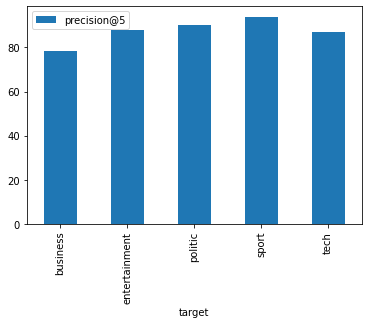

In [23]:
df_p5 = pd.DataFrame.from_dict(p5, orient='index', columns=['precision@5'])

df_p5["target"] =  target_names

d = df_p5.set_index("target")

d.plot.bar()

In [59]:
""" Sport es la clase que mejor se comporta al tener un 93.8% de precisión media
mientras que la clase que peor resultado de precisión media es la de business 
con un 78.18%. Los resultados son buenos y los resultados excepto en esta última
son buenos. """

' Sport es la clase que mejor se comporta al tener un 93.8% de precisión media\nmientras que la clase que peor resultado de precisión media es la de business \ncon un 78.18%. Los resultados son buenos y los resultados excepto en esta última\nson buenos. '

## 3) Representación basada en word-embeddings y tf-idf

La segunda vectorización que vamos a usar representará los mensajes usando usando word-embeddings usando como los pesos tf-idf de cada palabra. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test.

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y compara los resultados con los del apartado anterior.

In [25]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('words.txt', binary=False, no_header=True)

In [26]:
we_vocabulary = list(model.key_to_index.keys())

In [27]:
vectorizer2 = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary=False,ngram_range=(1,1))

In [28]:
train_data_vector2 = vectorizer2.fit_transform(x_train.Text)
test_data_vector2 = vectorizer2.transform(x_test.Text)

we_feature_names = vectorizer2.get_feature_names()

In [29]:
train_preprocessed2 = tfidfer.fit_transform(train_data_vector2)
test_preprocessed2 = tfidfer.transform(test_data_vector2)

In [30]:
p5_2 = mean_precisions_per_class(train_preprocessed2, x_train.Category, test_preprocessed2[:200,], x_test.Category[:200], 5)
    
p5_2

{'business': 80.45454545454545,
 'entertainment': 87.23404255319149,
 'politics': 91.72413793103448,
 'sport': 97.55102040816327,
 'tech': 87.09677419354838}

<AxesSubplot:xlabel='target'>

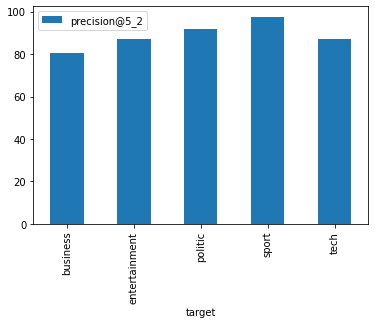

In [31]:
df_p5_2 = pd.DataFrame.from_dict(p5_2, orient='index', columns=['precision@5_2'])

df_p5_2["target"] =  target_names

d2 = df_p5_2.set_index("target")

d2.plot.bar()

In [62]:
""" {'business': 78.18181818181819 -> 80.45454545454545
 'entertainment': 88.08510638297872 -> 87.23404255319149
 'politics': 90.34482758620689 -> 91.72413793103448
 'sport': 93.87755102040816 -> 97.55102040816327
 'tech': 87.09677419354838 -> 87.09677419354838} """

" {'business': 78.18181818181819 -> 80.45454545454545\n 'entertainment': 88.08510638297872 -> 87.23404255319149\n 'politics': 90.34482758620689 -> 91.72413793103448\n 'sport': 93.87755102040816 -> 97.55102040816327\n 'tech': 87.09677419354838 -> 87.09677419354838} "

In [63]:
""" En conclusión comparando con los datos del apartado anterior vemos que mejoran
en todos menos en entertainment que la precisión disminuye ligeramente y en tech que no
aumenta ni disminuye. Sin embargo, en la clase Sport aumenta considerablemente 
la precisión media y en business y politics también mejora la precisión. 
En conjunto la predicción basada en word-embedings ha mejorado con respecto a la
tf-idf pura. """

' En conclusión comparando con los datos del apartado anterior vemos que mejoran\nen todos menos en entertainment que la precisión disminuye ligeramente y en tech que no\naumenta ni disminuye. Sin embargo, en la clase Sport aumenta considerablemente \nla precisión media y en business y politics también mejora la precisión. \nEn conjunto la predicción basada en word-embedings ha mejorado con respecto a la\ntf-idf pura. '

## 4) Análisis de errores

Vamos a investigar los resultados para entender mejor dónde están fallando los procesos de recuperación. Sigue los siguientes pasos.


1. Identifica la categoría de noticias donde la precisión media haya mejorado más al incorporar word-embeddings
2. Para dicha categoría, identifica la consulta donde la precisión haya mejorado más al usar word-embeddings
3. Muestra el texto original de la consulta y los términos que aparecen en las dos vectorizaciones tf-idf que usamos (recuerda que usamos diccionarios distintos para las vectorizaciones bolsa de palabras y word-embeddings).
4. Identifica las noticias recuperadas para dicha consulta para las dos aproximaciones y sus categorías (TF-IDF puro y con word-embeddings)
5. Muestra la intersección de términos entre la consulta y la primera noticia mal recuperada usando TF-IDF puro.
6. Muestra la intersección de términos entre la consulta y la última noticia bien recuperada usando word-embeddings.
7. A la luz de todo lo anterior, razona sobre por qué crees que el TF-IDF no fue capaz de clasificar bien la noticia y el word-embedding sí.


Puedes usar el código que calcula la intersección de términos que ponemos a continuación

In [36]:
def no_mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    i = 0
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append((i,precision))
        i+=1
    
    return y_precisions

In [55]:
""" La categoría Sport ha mejorado considerablemente con respecto al resto de
categorías por lo que la hemos elegido para este ejercicio."""

' La categoría Sport ha mejorado considerablemente con respecto al resto de\ncategorías por lo que la hemos elegido para este ejercicio.'

In [37]:
precisiones = no_mean_precisions_per_class(train_preprocessed2, x_train.Category, test_preprocessed2[:200,], x_test.Category[:200], 5)
precisiones['sport']

[(1, 100.0),
 (8, 100.0),
 (9, 100.0),
 (19, 100.0),
 (27, 80.0),
 (28, 20.0),
 (32, 100.0),
 (36, 100.0),
 (37, 100.0),
 (38, 100.0),
 (40, 100.0),
 (42, 100.0),
 (44, 100.0),
 (45, 100.0),
 (52, 100.0),
 (65, 100.0),
 (66, 100.0),
 (68, 100.0),
 (69, 100.0),
 (77, 100.0),
 (78, 100.0),
 (81, 100.0),
 (83, 100.0),
 (88, 80.0),
 (91, 100.0),
 (92, 100.0),
 (93, 100.0),
 (98, 100.0),
 (104, 100.0),
 (110, 100.0),
 (112, 100.0),
 (117, 100.0),
 (121, 100.0),
 (123, 100.0),
 (128, 100.0),
 (137, 100.0),
 (140, 100.0),
 (145, 100.0),
 (154, 100.0),
 (155, 100.0),
 (162, 100.0),
 (163, 100.0),
 (167, 100.0),
 (170, 100.0),
 (171, 100.0),
 (174, 100.0),
 (182, 100.0),
 (185, 100.0),
 (191, 100.0)]

In [38]:
precisionesAntes = no_mean_precisions_per_class(train_preprocessed, x_train.Category, test_preprocessed[:200,], x_test.Category[:200], 5)
precisionesAntes['sport']

[(1, 100.0),
 (8, 100.0),
 (9, 100.0),
 (19, 100.0),
 (27, 100.0),
 (28, 80.0),
 (32, 100.0),
 (36, 100.0),
 (37, 100.0),
 (38, 100.0),
 (40, 100.0),
 (42, 100.0),
 (44, 100.0),
 (45, 20.0),
 (52, 100.0),
 (65, 100.0),
 (66, 100.0),
 (68, 100.0),
 (69, 100.0),
 (77, 100.0),
 (78, 100.0),
 (81, 100.0),
 (83, 100.0),
 (88, 100.0),
 (91, 0.0),
 (92, 100.0),
 (93, 100.0),
 (98, 100.0),
 (104, 100.0),
 (110, 100.0),
 (112, 100.0),
 (117, 100.0),
 (121, 100.0),
 (123, 100.0),
 (128, 100.0),
 (137, 100.0),
 (140, 100.0),
 (145, 100.0),
 (154, 60.0),
 (155, 80.0),
 (162, 100.0),
 (163, 100.0),
 (167, 100.0),
 (170, 100.0),
 (171, 60.0),
 (174, 100.0),
 (182, 100.0),
 (185, 100.0),
 (191, 100.0)]

In [53]:
""" Consulta 91 ha pasado de 0.0 a 100.0, por lo que la tomamos al pasar de un 0% a un 100%."""

' Consulta 91 ha pasado de 0.0 a 100.0, por lo que la tomamos al pasar de un 0% a un 100%.'

In [42]:
write_terms(feature_names, x_test.Text.tolist(), test_preprocessed, 91)

Mensaje 91 : tevez - an argentine in brazil some 65 years ago bernardo gandulla left boca juniors in his native argentina and headed for brazil.  he arrived at the vasco da gama club with considerable prestige - which he failed to live up to. he left an impression  but not for reasons he would have wanted. the only thing of note he did was to throw the ball back when it went out of play. even today   gandula  is the term used in brazil for ballboy. brazilians delighted in the failure of gandulla then  and many will delight now if history is repeated. another boca juniors player is coming to brazil.  the new maradona  - carlos tevez - is joining corinthians for nearly $20m in a strong candidate for the strangest move of the year. corinthians - or the london-based company who have just entered into partnership with them - appear to have paid well above the odds for tevez. it is particularly strange as - until last week - tevez was not even an especially big name in brazil  where the arge

In [43]:
write_terms(we_vocabulary, None, test_preprocessed2, 91)

Mensaje 91 vectorizado: ['able' 'acquainted' 'ago' 'ambushed' 'appalling' 'appear' 'arrived'
 'attack' 'based' 'big' 'biggest' 'brazilians' 'brightest' 'buried'
 'candidate' 'capable' 'catch' 'champions' 'championship' 'charge'
 'choice' 'cities' 'club' 'coach' 'coming' 'company' 'considerable' 'copa'
 'declaration' 'declaring' 'defenders' 'delighted' 'destination'
 'disorganized' 'dressing' 'dribble' 'easy' 'end' 'entered' 'especially'
 'expected' 'failed' 'failure' 'fans' 'favoured' 'feint' 'financial'
 'foolish' 'forcing' 'form' 'frenetic' 'game' 'gave' 'gets' 'gift' 'gives'
 'goalkeeper' 'goals' 'goodbye' 'harder' 'headed' 'heading' 'hysterical'
 'history' 'hit' 'hounded' 'year' 'years' 'immigrants' 'impression'
 'interested' 'invaded' 'joining' 'juniors' 'kick' 'league' 'left' 'level'
 'lies' 'like' 'live' 'logic' 'long' 'make' 'match' 'matches' 'medal'
 'melancholy' 'months' 'native' 'nearly' 'nonsense' 'note' 'nowadays'
 'paid' 'particularly' 'partnership' 'passionately' 'pitch'

In [45]:
x_test.Text[151]

'tevez - an argentine in brazil some 65 years ago bernardo gandulla left boca juniors in his native argentina and headed for brazil.  he arrived at the vasco da gama club with considerable prestige - which he failed to live up to. he left an impression  but not for reasons he would have wanted. the only thing of note he did was to throw the ball back when it went out of play. even today   gandula  is the term used in brazil for ballboy. brazilians delighted in the failure of gandulla then  and many will delight now if history is repeated. another boca juniors player is coming to brazil.  the new maradona  - carlos tevez - is joining corinthians for nearly $20m in a strong candidate for the strangest move of the year. corinthians - or the london-based company who have just entered into partnership with them - appear to have paid well above the odds for tevez. it is particularly strange as - until last week - tevez was not even an especially big name in brazil  where the argentine champi

In [46]:
x_test.Category[151]

'sport'

In [39]:
idx = knn(test_preprocessed[91,], train_preprocessed, 5)
y_selected = np.take(x_train.Category, idx)
y_selected

502    business
261    business
484    business
474    business
711    business
Name: Category, dtype: object

In [40]:
idx = knn(test_preprocessed2[91,], train_preprocessed2, 5)
y_selected = np.take(x_train.Category, idx)
y_selected

1111    sport
389     sport
59      sport
169     sport
1003    sport
Name: Category, dtype: object

In [50]:
""" En la consulta 91 del TF-IDF puro lo califica como bussines 
mientras que el que usa word_embeddings lo califica correctamente como sport """

' En la consulta 91 del TF-IDF puro lo califica como bussines \nmientras que el que usa word_embeddings lo califica correctamente como sport '

In [49]:
def terms_in_message(feature_names,vector_data,index):
    '''
    Devuelve un conjunto los términos presentes en un mensaje representado como bolsa de palabras.

    - feature_names: terminos usados para vectorizar
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    mensaje=vector_data[index,:]>0
    terminos_presentes = ma.array(feature_names, mask = ~(mensaje[0].toarray()))

    return set(terminos_presentes.compressed())

In [51]:
cons = terms_in_message(feature_names,test_preprocessed,91)
rec = terms_in_message(feature_names,train_preprocessed,502)

for elem in cons:
    if elem in rec:
        print(elem)

say
centre
says
months
used
world
gets
small
especially
way


In [52]:
cons = terms_in_message(we_feature_names,test_preprocessed2,91)
rec = terms_in_message(we_feature_names,train_preprocessed2,1003)

for elem in cons:
    if elem in rec:
        print(elem)

level
ago
big
match
coming
like
year
history
game
week
world
wanted


In [64]:
""" Con el TF-IDF puro no hemos encontrado ninguna palabra muy determinante para
encontrar la categoría correcta de la noticia al ser palabras muy genéricas.

Mientras que con el word-embedding hemos encontrado palabras como 'level', 'match'
o 'game' que guardan mayor relación con la temática de 'sport' """

" Con el TF-IDF puro no hemos encontrado ninguna palabra muy determinante para\nencontrar la categoría correcta de la noticia al ser palabras muy genéricas.\n\nMientras que con el word-embedding hemos encontrado palabras como 'level', 'match'\no 'game' que guardan mayor relación con la temática de 'sport' "